# Prediction of the rental price of housing in the city of Barcelona

Dataset description:

|Column|Description|Key|
|--|--|--|
|id|Numerical identifier of the dwelling||
|price|Market price of housing||
|currency|Currency|Euros|
|latitude|Latitude of the geographical coordinates of the dwelling||
|longitude|Longitude of the geographical coordinates of the dwelling||
|sq_meters|Square meters of housing||
|sq_meters_built|Square meters built of the house||
|rooms|Number of rooms||
|bathrooms|Number of bathrooms||
|balcony|Indicator if the dwelling has a balcony|1, 0|
|terrace|Indicator if the dwelling has a terrace|1, 0|
|exterior|Indicator if the dwelling has an exterior or interior orientation in the building|1, 0|
|orientation|Main orientation of the home|north, south, east, west|
|floor|Floor of the dwelling||
|rooftop|Indicator if the dwelling is an attic|1, 0|
|elevator|Indicator if the dwelling building has an elevator|1, 0|
|doorman|Indicator if the building has a doorman|1,0|
|pool|Indicator if the dwelling has a swimming pool or the right to use a swimming pool|1.0|
|ac|Indicator if it has air conditioning|1,0|
|heating|Indicator if it has heating|pump, electric, gas, individual|
|year_built|Year Built||
|quality|Housing quality indicator|2 - In good condition|
|city|City of housing||
|neighborhood|Housing neighborhood||
|dist_city_center|Distance in kilometers to the city center||
|furniture|Indicator if the dwelling has furniture|1: Not Equipped; 2: Equipped Kitchen; 3: Furnished|
|garage|Indicator if the dwelling has a garage|1, 0|
|property_type|Type of property||
|garden|Indicator if the dwelling has a garden|1.0|
|closest_station|Name of the nearest metro station||
|dist_closest_station|Distance in kilometers to the nearest metro station||
|created_at|Ad creation date||
|last_seen|Last date the ad was published on the web||

In [1]:
# Library load
import os
import pandas as pd
import numpy as np

# Plotting library
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics calculations 
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math 

# sklearn packages
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics 
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import GridSearchCV 

# Confusion matrix viz
from mlxtend.evaluate import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix 

# Catboost & shap 
import catboost
import shap
# print the JS visualization code to the notebook 
shap.initjs()

# Ignoring warning messaages
import warnings
warnings.filterwarnings('ignore') 

# Data Cleaning 

In [2]:
raw_data = pd.read_csv('processed_sale_Barcelona.csv', delimiter = ',')
pd.set_option('max_columns', None)
raw_data.head()

,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,doorman,pool,ac,heating,year_built,quality,city,neighborhood,dist_city_center,furniture,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen
0,320294,150000,€,41.459649,2.174793,63.0,67,3,1,NaN,1.0,1.0,este,5.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,2,Barcelona,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,NaN,NaN,piso,NaN,Ciutat Meridiana,0.121438,9/3/2021 10:16,11/12/2021 13:50
1,1786997,150000,€,41.422081,2.155370,48.0,52,2,1,NaN,NaN,1.0,NaN,3.0,NaN,0.0,NaN,NaN,1.0,individual,NaN,2,Barcelona,El Carmel,3.991000,NaN,NaN,piso,NaN,El Carmel,0.277336,9/3/2021 10:16,11/12/2021 13:50
2,1787143,395000,€,41.402928,2.207851,84.0,91,2,2,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,electric,NaN,2,Barcelona,El Poblenou,3.579261,NaN,NaN,duplex,NaN,Poblenou,0.383878,8/30/2021 12:17,8/30/2021 12:17
3,1976767,540000,€,41.394692,2.144422,NaN,100,3,1,NaN,NaN,1.0,sur,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2,Barcelona,Sant Gervasi - Galvany,2.257852,NaN,1.0,piso,NaN,Hospital Clínic,0.875652,9/1/2021 14:04,9/2/2021 13:50
4,27972575,650000,€,41.398971,2.120754,NaN,141,3,2,NaN,NaN,1.0,este,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2,Barcelona,Sarrià,4.283368,NaN,1.0,piso,NaN,Maria Cristina,1.310073,8/29/2021 11:47,9/2/2021 11:01


In [3]:
raw_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,doorman,pool,ac,year_built,quality,dist_city_center,furniture,garage,garden,dist_closest_station
count,5847.00,5847.00,5847.00,5847.00,3274.00,5847.00,5847.00,5847.00,2210.00,1428.00,4770.00,3765.00,407.00,5276.00,0.00,170.00,2649.00,4082.00,5847.00,5847.00,0.00,405.00,61.00,5847.00
mean,93478251.37,367527.74,41.41,2.17,71.47,86.80,2.60,1.42,1.00,1.00,0.87,3.20,1.00,0.63,nan,1.00,1.00,1954.56,2.00,3.50,nan,1.00,1.00,0.36
std,6163703.73,529709.69,0.03,0.02,51.39,67.54,1.16,0.80,0.00,0.00,0.33,2.35,0.00,0.48,nan,0.00,0.00,36.55,0.00,2.02,nan,0.00,0.00,0.29
min,320294.00,28000.00,41.36,2.09,2.00,10.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,nan,1.00,1.00,1769.00,2.00,0.07,nan,1.00,1.00,0.00
25%,93771881.50,135000.00,41.38,2.15,48.00,55.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,nan,1.00,1.00,1940.00,2.00,1.76,nan,1.00,1.00,0.21
50%,94967812.00,192000.00,41.40,2.17,60.00,69.00,3.00,1.00,1.00,1.00,1.00,3.00,1.00,1.00,nan,1.00,1.00,1965.00,2.00,3.38,nan,1.00,1.00,0.31
75%,95131865.50,395000.00,41.42,2.18,79.00,93.00,3.00,2.00,1.00,1.00,1.00,4.00,1.00,1.00,nan,1.00,1.00,1973.00,2.00,4.90,nan,1.00,1.00,0.42
max,95893914.00,9500000.00,41.47,2.22,900.00,970.00,11.00,9.00,1.00,1.00,1.00,25.00,1.00,1.00,nan,1.00,1.00,2022.00,2.00,8.63,nan,1.00,1.00,4.20


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5847 entries, 0 to 5846
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5847 non-null   int64  
 1   price                 5847 non-null   int64  
 2   currency              5847 non-null   object 
 3   latitude              5847 non-null   float64
 4   longitude             5847 non-null   float64
 5   sq_meters             3274 non-null   float64
 6   sq_meters_built       5847 non-null   int64  
 7   rooms                 5847 non-null   int64  
 8   bathrooms             5847 non-null   int64  
 9   balcony               2210 non-null   float64
 10  terrace               1428 non-null   float64
 11  exterior              4770 non-null   float64
 12  orientation           3134 non-null   object 
 13  floor                 3765 non-null   float64
 14  rooftop               407 non-null    float64
 15  elevator             

In [5]:
raw_data.isnull().sum() / len(raw_data) # Calcula la proporción de null values sobre todas las variables

id                      0.000000
price                   0.000000
currency                0.000000
latitude                0.000000
longitude               0.000000
sq_meters               0.440055
sq_meters_built         0.000000
rooms                   0.000000
bathrooms               0.000000
balcony                 0.622028
terrace                 0.755772
exterior                0.184197
orientation             0.463999
floor                   0.356080
rooftop                 0.930392
elevator                0.097657
doorman                 1.000000
pool                    0.970925
ac                      0.546947
heating                 0.425859
year_built              0.301864
quality                 0.000000
city                    0.000000
neighborhood            0.000000
dist_city_center        0.000000
furniture               1.000000
garage                  0.930734
property_type           0.000342
garden                  0.989567
closest_station         0.000000
dist_close

In [6]:
#removing columns that have 100% NaN values 
raw_data = raw_data.drop(['doorman', 'furniture'], axis=1) # Retira columnas que no nos sean útiles en el dataset

In [7]:
raw_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,pool,ac,year_built,quality,dist_city_center,garage,garden,dist_closest_station
count,5847.00,5847.00,5847.00,5847.00,3274.00,5847.00,5847.00,5847.00,2210.00,1428.00,4770.00,3765.00,407.00,5276.00,170.00,2649.00,4082.00,5847.00,5847.00,405.00,61.00,5847.00
mean,93478251.37,367527.74,41.41,2.17,71.47,86.80,2.60,1.42,1.00,1.00,0.87,3.20,1.00,0.63,1.00,1.00,1954.56,2.00,3.50,1.00,1.00,0.36
std,6163703.73,529709.69,0.03,0.02,51.39,67.54,1.16,0.80,0.00,0.00,0.33,2.35,0.00,0.48,0.00,0.00,36.55,0.00,2.02,0.00,0.00,0.29
min,320294.00,28000.00,41.36,2.09,2.00,10.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,1.00,1769.00,2.00,0.07,1.00,1.00,0.00
25%,93771881.50,135000.00,41.38,2.15,48.00,55.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1940.00,2.00,1.76,1.00,1.00,0.21
50%,94967812.00,192000.00,41.40,2.17,60.00,69.00,3.00,1.00,1.00,1.00,1.00,3.00,1.00,1.00,1.00,1.00,1965.00,2.00,3.38,1.00,1.00,0.31
75%,95131865.50,395000.00,41.42,2.18,79.00,93.00,3.00,2.00,1.00,1.00,1.00,4.00,1.00,1.00,1.00,1.00,1973.00,2.00,4.90,1.00,1.00,0.42
max,95893914.00,9500000.00,41.47,2.22,900.00,970.00,11.00,9.00,1.00,1.00,1.00,25.00,1.00,1.00,1.00,1.00,2022.00,2.00,8.63,1.00,1.00,4.20


In [8]:
#replace values of (0 or 1) categorical variables that have NaN with 0 

cols_to_null = ['balcony', 'terrace', 'exterior', 'elevator', 'ac', 'rooftop', 'pool','garage','garden']
for i in range(0,len(cols_to_null)):
    raw_data[cols_to_null[1]].fillna(0, inplace = True) 



In [9]:
raw_data["balcony"].fillna(0, inplace=True)
raw_data["terrace"].fillna(0, inplace=True)
raw_data["exterior"].fillna(0, inplace=True)
raw_data["elevator"].fillna(0, inplace=True)
raw_data["ac"].fillna(0, inplace=True)
raw_data["balcony"].fillna(0, inplace=True)
raw_data["pool"].fillna(0, inplace=True)
raw_data["garage"].fillna(0, inplace=True)
raw_data["garden"].fillna(0, inplace=True)
raw_data["rooftop"].fillna(0, inplace=True)

In [10]:
raw_data.isnull().sum() / len(raw_data) # Calcula la proporción de null values sobre todas las variables

id                      0.000000
price                   0.000000
currency                0.000000
latitude                0.000000
longitude               0.000000
sq_meters               0.440055
sq_meters_built         0.000000
rooms                   0.000000
bathrooms               0.000000
balcony                 0.000000
terrace                 0.000000
exterior                0.000000
orientation             0.463999
floor                   0.356080
rooftop                 0.000000
elevator                0.000000
pool                    0.000000
ac                      0.000000
heating                 0.425859
year_built              0.301864
quality                 0.000000
city                    0.000000
neighborhood            0.000000
dist_city_center        0.000000
garage                  0.000000
property_type           0.000342
garden                  0.000000
closest_station         0.000000
dist_closest_station    0.000000
created_at              0.000000
last_seen 

In [11]:
#raw_data["rooftop"].fillna(0, inplace=True)

In [12]:
raw_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,pool,ac,year_built,quality,dist_city_center,garage,garden,dist_closest_station
count,5847.00,5847.00,5847.00,5847.00,3274.00,5847.00,5847.00,5847.00,5847.00,5847.00,5847.00,3765.00,5847.00,5847.00,5847.00,5847.00,4082.00,5847.00,5847.00,5847.00,5847.00,5847.00
mean,93478251.37,367527.74,41.41,2.17,71.47,86.80,2.60,1.42,0.38,0.24,0.71,3.20,0.07,0.57,0.03,0.45,1954.56,2.00,3.50,0.07,0.01,0.36
std,6163703.73,529709.69,0.03,0.02,51.39,67.54,1.16,0.80,0.48,0.43,0.45,2.35,0.25,0.50,0.17,0.50,36.55,0.00,2.02,0.25,0.10,0.29
min,320294.00,28000.00,41.36,2.09,2.00,10.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1769.00,2.00,0.07,0.00,0.00,0.00
25%,93771881.50,135000.00,41.38,2.15,48.00,55.00,2.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1940.00,2.00,1.76,0.00,0.00,0.21
50%,94967812.00,192000.00,41.40,2.17,60.00,69.00,3.00,1.00,0.00,0.00,1.00,3.00,0.00,1.00,0.00,0.00,1965.00,2.00,3.38,0.00,0.00,0.31
75%,95131865.50,395000.00,41.42,2.18,79.00,93.00,3.00,2.00,1.00,0.00,1.00,4.00,0.00,1.00,0.00,1.00,1973.00,2.00,4.90,0.00,0.00,0.42
max,95893914.00,9500000.00,41.47,2.22,900.00,970.00,11.00,9.00,1.00,1.00,1.00,25.00,1.00,1.00,1.00,1.00,2022.00,2.00,8.63,1.00,1.00,4.20


In [13]:
#removing rows where values are blank 
raw_data = raw_data.dropna(subset=['property_type'])
raw_data['sq_meters'] = raw_data['sq_meters'].fillna(raw_data['sq_meters'].mean())
raw_data['floor'] = raw_data['floor'].fillna(raw_data['floor'].median())
raw_data['year_built'] = raw_data['year_built'].fillna(raw_data['year_built'].median())

In [14]:
raw_data.isnull().sum() / len(raw_data) # Calcula la proporción de null values sobre todas las variables

id                      0.000000
price                   0.000000
currency                0.000000
latitude                0.000000
longitude               0.000000
sq_meters               0.000000
sq_meters_built         0.000000
rooms                   0.000000
bathrooms               0.000000
balcony                 0.000000
terrace                 0.000000
exterior                0.000000
orientation             0.463815
floor                   0.000000
rooftop                 0.000000
elevator                0.000000
pool                    0.000000
ac                      0.000000
heating                 0.426005
year_built              0.000000
quality                 0.000000
city                    0.000000
neighborhood            0.000000
dist_city_center        0.000000
garage                  0.000000
property_type           0.000000
garden                  0.000000
closest_station         0.000000
dist_closest_station    0.000000
created_at              0.000000
last_seen 

In [15]:
raw_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,pool,ac,year_built,quality,dist_city_center,garage,garden,dist_closest_station
count,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00,5845.00
mean,93478197.01,366455.89,41.41,2.17,71.35,86.64,2.59,1.42,0.38,0.24,0.71,3.13,0.07,0.57,0.03,0.45,1957.71,2.00,3.50,0.07,0.01,0.36
std,6164698.18,525624.44,0.03,0.02,38.15,66.99,1.15,0.80,0.48,0.43,0.45,1.89,0.25,0.50,0.17,0.50,30.90,0.00,2.02,0.25,0.10,0.28
min,320294.00,28000.00,41.36,2.09,2.00,10.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1769.00,2.00,0.07,0.00,0.00,0.00
25%,93772764.00,135000.00,41.38,2.15,58.00,55.00,2.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,1960.00,2.00,1.76,0.00,0.00,0.21
50%,94967812.00,190000.00,41.40,2.17,71.35,69.00,3.00,1.00,0.00,0.00,1.00,3.00,0.00,1.00,0.00,0.00,1965.00,2.00,3.38,0.00,0.00,0.31
75%,95131888.00,395000.00,41.42,2.18,71.35,93.00,3.00,2.00,1.00,0.00,1.00,3.00,0.00,1.00,0.00,1.00,1969.00,2.00,4.90,0.00,0.00,0.42
max,95893914.00,9500000.00,41.47,2.22,900.00,970.00,11.00,9.00,1.00,1.00,1.00,25.00,1.00,1.00,1.00,1.00,2022.00,2.00,8.63,1.00,1.00,4.20


In [16]:
#clean_data = raw_data.dropna(subset = ['heating', 'orientation'], inplace=True)

In [17]:
#raw_data.describe().apply(lambda s: s.apply('{0:.2f}'.format))

In [18]:
raw_data['property_age'] = 2022 - raw_data['year_built']

In [19]:
def conditions(x):
    if x < 0:
        return "Unknown"
    elif ((x >= 0) & (x < 40)):
        return "0 - 40"
    elif ((x >= 40) & (x < 70)):
        return "40 - 70"
    elif ((x >= 70) & (x < 120)):
        return "70 - 120"
    elif ((x >= 120) & (x < 150)):
        return "120 - 150"
    elif ((x >= 150)):
        return "+150"
    else:
        return "Unknown"

func = np.vectorize(conditions)
raw_data['property_age_cat'] = func(raw_data['property_age'])

In [20]:
def conditions(y):
    if ((y >= 0) & (y < .20)):
        return "very close to train"
    elif ((y >= .21) & (y < .31)):
        return "close to train"
    elif ((y >= .31) & (y < .42)):
        return "far from train"
    elif ((y >= .43) & (y < .52)):
        return "very far from train"
    elif ((y >= .53)):
        return "extremely far from train"


func2 = np.vectorize(conditions)
raw_data['dist_closest_station_cat'] = func2(raw_data['dist_closest_station'])
raw_data.head()

,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,year_built,quality,city,neighborhood,dist_city_center,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen,property_age,property_age_cat,dist_closest_station_cat
0,320294,150000,€,41.459649,2.174793,63.000000,67,3,1,0.0,1.0,1.0,este,5.0,0.0,0.0,0.0,1.0,NaN,1965.0,2,Barcelona,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,0.0,piso,0.0,Ciutat Meridiana,0.121438,9/3/2021 10:16,11/12/2021 13:50,57.0,40 - 70,very close to train
1,1786997,150000,€,41.422081,2.155370,48.000000,52,2,1,0.0,0.0,1.0,NaN,3.0,0.0,0.0,0.0,1.0,individual,1965.0,2,Barcelona,El Carmel,3.991000,0.0,piso,0.0,El Carmel,0.277336,9/3/2021 10:16,11/12/2021 13:50,57.0,40 - 70,close to train
2,1787143,395000,€,41.402928,2.207851,84.000000,91,2,2,0.0,0.0,1.0,NaN,3.0,0.0,0.0,0.0,1.0,electric,1965.0,2,Barcelona,El Poblenou,3.579261,0.0,duplex,0.0,Poblenou,0.383878,8/30/2021 12:17,8/30/2021 12:17,57.0,40 - 70,far from train
3,1976767,540000,€,41.394692,2.144422,71.354415,100,3,1,0.0,0.0,1.0,sur,1.0,0.0,1.0,0.0,1.0,NaN,1965.0,2,Barcelona,Sant Gervasi - Galvany,2.257852,1.0,piso,0.0,Hospital Clínic,0.875652,9/1/2021 14:04,9/2/2021 13:50,57.0,40 - 70,extremely far from train
4,27972575,650000,€,41.398971,2.120754,71.354415,141,3,2,0.0,0.0,1.0,este,1.0,0.0,1.0,0.0,1.0,NaN,1965.0,2,Barcelona,Sarrià,4.283368,1.0,piso,0.0,Maria Cristina,1.310073,8/29/2021 11:47,9/2/2021 11:01,57.0,40 - 70,extremely far from train


In [21]:
def conditions(z):
    if ((z >= 0) & (z < 1.76)):
        return "very close to city center"
    elif ((z >= 1.77) & (z < 3.38)):
        return "close to city center"
    elif ((z >= 3.39) & (z < 4.9)):
        return "far from city center"
    elif ((z >= 4.91) & (z < 6.91)):
        return "very far city center"
    elif ((z >= 6.92)):
        return "extremely far city center"


func3 = np.vectorize(conditions)
raw_data['dist_city_center_cat'] = func3(raw_data['dist_city_center'])
raw_data.head()

,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,year_built,quality,city,neighborhood,dist_city_center,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen,property_age,property_age_cat,dist_closest_station_cat,dist_city_center_cat
0,320294,150000,€,41.459649,2.174793,63.000000,67,3,1,0.0,1.0,1.0,este,5.0,0.0,0.0,0.0,1.0,NaN,1965.0,2,Barcelona,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,0.0,piso,0.0,Ciutat Meridiana,0.121438,9/3/2021 10:16,11/12/2021 13:50,57.0,40 - 70,very close to train,extremely far city center
1,1786997,150000,€,41.422081,2.155370,48.000000,52,2,1,0.0,0.0,1.0,NaN,3.0,0.0,0.0,0.0,1.0,individual,1965.0,2,Barcelona,El Carmel,3.991000,0.0,piso,0.0,El Carmel,0.277336,9/3/2021 10:16,11/12/2021 13:50,57.0,40 - 70,close to train,far from city center
2,1787143,395000,€,41.402928,2.207851,84.000000,91,2,2,0.0,0.0,1.0,NaN,3.0,0.0,0.0,0.0,1.0,electric,1965.0,2,Barcelona,El Poblenou,3.579261,0.0,duplex,0.0,Poblenou,0.383878,8/30/2021 12:17,8/30/2021 12:17,57.0,40 - 70,far from train,far from city center
3,1976767,540000,€,41.394692,2.144422,71.354415,100,3,1,0.0,0.0,1.0,sur,1.0,0.0,1.0,0.0,1.0,NaN,1965.0,2,Barcelona,Sant Gervasi - Galvany,2.257852,1.0,piso,0.0,Hospital Clínic,0.875652,9/1/2021 14:04,9/2/2021 13:50,57.0,40 - 70,extremely far from train,close to city center
4,27972575,650000,€,41.398971,2.120754,71.354415,141,3,2,0.0,0.0,1.0,este,1.0,0.0,1.0,0.0,1.0,NaN,1965.0,2,Barcelona,Sarrià,4.283368,1.0,piso,0.0,Maria Cristina,1.310073,8/29/2021 11:47,9/2/2021 11:01,57.0,40 - 70,extremely far from train,far from city center


In [22]:
def conditions(a):
    if ((a >= 28000) & (a < 135000)):
        return "very cheap price"
    elif ((a >= 135000) & (a < 190000)):
        return "cheap price"
    elif ((a >= 190000) & (a < 395000)):
        return "moderate price"
    elif ((a >= 395000) & (a < 920624)):
        return "expensive"
    elif ((a >= 920624)):
        return "very expensive"


func4 = np.vectorize(conditions)
raw_data['price_cat'] = func4(raw_data['price'])
raw_data.head()

,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,orientation,floor,rooftop,elevator,pool,ac,heating,year_built,quality,city,neighborhood,dist_city_center,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen,property_age,property_age_cat,dist_closest_station_cat,dist_city_center_cat,price_cat
0,320294,150000,€,41.459649,2.174793,63.000000,67,3,1,0.0,1.0,1.0,este,5.0,0.0,0.0,0.0,1.0,NaN,1965.0,2,Barcelona,Ciutat Meridiana - Torre Baró - Vallbona,7.990993,0.0,piso,0.0,Ciutat Meridiana,0.121438,9/3/2021 10:16,11/12/2021 13:50,57.0,40 - 70,very close to train,extremely far city center,cheap price
1,1786997,150000,€,41.422081,2.155370,48.000000,52,2,1,0.0,0.0,1.0,NaN,3.0,0.0,0.0,0.0,1.0,individual,1965.0,2,Barcelona,El Carmel,3.991000,0.0,piso,0.0,El Carmel,0.277336,9/3/2021 10:16,11/12/2021 13:50,57.0,40 - 70,close to train,far from city center,cheap price
2,1787143,395000,€,41.402928,2.207851,84.000000,91,2,2,0.0,0.0,1.0,NaN,3.0,0.0,0.0,0.0,1.0,electric,1965.0,2,Barcelona,El Poblenou,3.579261,0.0,duplex,0.0,Poblenou,0.383878,8/30/2021 12:17,8/30/2021 12:17,57.0,40 - 70,far from train,far from city center,expensive
3,1976767,540000,€,41.394692,2.144422,71.354415,100,3,1,0.0,0.0,1.0,sur,1.0,0.0,1.0,0.0,1.0,NaN,1965.0,2,Barcelona,Sant Gervasi - Galvany,2.257852,1.0,piso,0.0,Hospital Clínic,0.875652,9/1/2021 14:04,9/2/2021 13:50,57.0,40 - 70,extremely far from train,close to city center,expensive
4,27972575,650000,€,41.398971,2.120754,71.354415,141,3,2,0.0,0.0,1.0,este,1.0,0.0,1.0,0.0,1.0,NaN,1965.0,2,Barcelona,Sarrià,4.283368,1.0,piso,0.0,Maria Cristina,1.310073,8/29/2021 11:47,9/2/2021 11:01,57.0,40 - 70,extremely far from train,far from city center,expensive


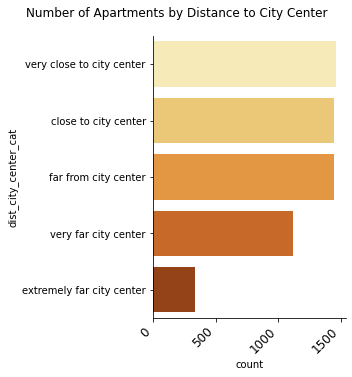

In [23]:
center_chart = sn.catplot(y = 'dist_city_center_cat', palette="YlOrBr", kind = 'count', order=['very close to city center','close to city center','far from city center', 'very far city center','extremely far city center'],data = raw_data) 

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large' )

center_chart.fig.subplots_adjust(top=0.9)
center_chart.fig.suptitle('Number of Apartments by Distance to City Center')


None

In [24]:
close_to_center = ['very close to city center', 'close to city center']
    
close_apts = raw_data[raw_data['dist_city_center_cat'].isin(close_to_center)]

In [25]:
close_apts.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,pool,ac,year_built,quality,dist_city_center,garage,garden,dist_closest_station,property_age
count,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00,2913.00
mean,93364374.28,446315.92,41.39,2.16,73.47,91.57,2.49,1.56,0.45,0.29,0.74,3.04,0.08,0.66,0.02,0.57,1948.09,2.00,1.81,0.06,0.00,0.36,73.91
std,6161682.86,440248.54,0.01,0.02,32.10,61.63,1.27,0.78,0.50,0.46,0.44,1.61,0.27,0.48,0.12,0.49,38.81,0.00,0.84,0.24,0.06,0.22,38.81
min,1976767.00,29000.00,41.36,2.13,12.00,13.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1769.00,2.00,0.07,0.00,0.00,0.01,1.00
25%,93713404.00,157500.00,41.38,2.15,66.00,52.00,2.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,1930.00,2.00,1.09,0.00,0.00,0.22,55.00
50%,94935420.00,325000.00,41.39,2.17,71.35,76.00,3.00,1.00,0.00,0.00,1.00,3.00,0.00,1.00,0.00,1.00,1965.00,2.00,1.75,0.00,0.00,0.32,57.00
75%,95115195.00,532000.00,41.40,2.18,71.35,110.00,3.00,2.00,1.00,1.00,1.00,3.00,0.00,1.00,0.00,1.00,1967.00,2.00,2.49,0.00,0.00,0.43,92.00
max,95892003.00,6500000.00,41.42,2.21,553.00,880.00,9.00,7.00,1.00,1.00,1.00,25.00,1.00,1.00,1.00,1.00,2021.00,2.00,3.38,1.00,1.00,1.45,253.00


In [26]:
mean_close = close_apts['price'].mean()
mean_all = raw_data['price'].mean()

print("Average price of Apartments Close to City Center: €", end="")
print(math.trunc(mean_close))
print("Average price of All Apartments: €", end="")
print(math.trunc(mean_all))

print('____________________________________')

size_mean_close = close_apts['sq_meters'].mean()
size_mean_all = raw_data['sq_meters'].mean()

print("Average Sq Ft of Apartments Close to City Center: ", end="")
print(math.trunc(size_mean_close))
print("Average Sq Ft of All Apartments: ", end="")
print(math.trunc(size_mean_all))

print('____________________________________')

yr_mean_close = close_apts['year_built'].mean()
yr_mean_all = raw_data['year_built'].mean()
print("Average Year Built of Apartments Close to City Center: ", end="")
print(math.trunc(yr_mean_close))
print("Average Year Built of All Apartments: ", end="")
print(math.trunc(yr_mean_all))


Average price of Apartments Close to City Center: €446315
Average price of All Apartments: €366455
____________________________________
Average Sq Ft of Apartments Close to City Center: 73
Average Sq Ft of All Apartments: 71
____________________________________
Average Year Built of Apartments Close to City Center: 1948
Average Year Built of All Apartments: 1957


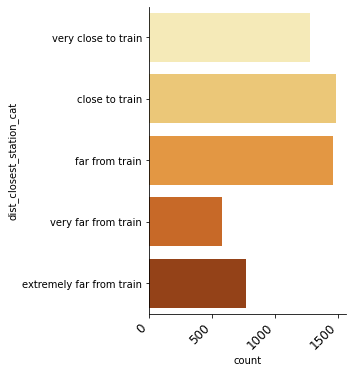

In [27]:
station_chart = sn.catplot(y = 'dist_closest_station_cat', palette="YlOrBr", kind = 'count', order=['very close to train',"close to train", "far from train", "very far from train","extremely far from train" ],data = raw_data) 

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large' )

None


In [28]:
close_to_center_and_station = ['very close to train',"close to train"]
    
apts = close_apts[close_apts['dist_closest_station_cat'].isin(close_to_center_and_station)]

In [29]:
apts.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,rooftop,elevator,pool,ac,year_built,quality,dist_city_center,garage,garden,dist_closest_station,property_age
count,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00,1345.00
mean,93260364.36,426877.01,41.39,2.17,71.59,87.85,2.43,1.52,0.49,0.29,0.74,3.00,0.07,0.65,0.01,0.58,1943.88,2.00,1.62,0.02,0.00,0.20,78.12
std,6596806.07,425333.44,0.01,0.01,25.21,53.49,1.19,0.74,0.50,0.45,0.44,1.50,0.26,0.48,0.10,0.49,40.93,0.00,0.83,0.15,0.03,0.08,40.93
min,29714252.00,35000.00,41.37,2.13,15.00,13.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1769.00,2.00,0.07,0.00,0.00,0.01,1.00
25%,93612478.00,158000.00,41.38,2.16,67.00,52.00,2.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,1910.00,2.00,0.97,0.00,0.00,0.15,57.00
50%,94967870.00,312000.00,41.38,2.17,71.35,75.00,2.00,1.00,0.00,0.00,1.00,3.00,0.00,1.00,0.00,1.00,1965.00,2.00,1.41,0.00,0.00,0.22,57.00
75%,95117405.00,486900.00,41.40,2.18,71.35,106.00,3.00,2.00,1.00,1.00,1.00,3.00,0.00,1.00,0.00,1.00,1965.00,2.00,2.24,0.00,0.00,0.27,112.00
max,95892003.00,5000000.00,41.42,2.21,300.00,582.00,9.00,7.00,1.00,1.00,1.00,14.00,1.00,1.00,1.00,1.00,2021.00,2.00,3.38,1.00,1.00,0.31,253.00


In [125]:
mean_apts = apts['price'].mean()
mean_all = raw_data['price'].mean()

print("Average price of Apartments Close to City Center & Station: €", end="")
print(math.trunc(mean_apts))
print("Average price of All Apartments: €", end="")
print(math.trunc(mean_all))
print('____________________________________')

size_mean_apts = apts['sq_meters_built'].mean()
size_mean_all = raw_data['sq_meters_built'].mean()

print("Average Sq Ft of Apartments Close to City Center & Station: ", end="")
print(math.trunc(size_mean_apts))
print("Average Sq Ft of All Apartments: ", end="")
print(math.trunc(size_mean_all))
print('____________________________________')

yr_mean_apts = apts['year_built'].mean()
yr_mean_all = raw_data['year_built'].mean()

print("Average Year Built of Apartments Close to City Center & Station: ", end="")
print(math.trunc(yr_mean_apts))
print("Average Year Built of All Apartments: ", end="")
print(math.trunc(yr_mean_apts))
print('____________________________________')

train_mean_apts = apts['dist_closest_station'].mean()
train_mean_all = raw_data['dist_closest_station'].mean()

print("Average Distance to Station: Apartments Close to City Center & Station: ", end="")
print(math.trunc(train_mean_apts))
print("Average Distance to Station: All Apartments: ", end="")
print(math.trunc(train_mean_all))



Average price of Apartments Close to City Center & Station: €426877
Average price of All Apartments: €366455
____________________________________
Average Sq Ft of Apartments Close to City Center & Station: 87
Average Sq Ft of All Apartments: 86
____________________________________
Average Year Built of Apartments Close to City Center & Station: 1943
Average Year Built of All Apartments: 1943
____________________________________
Average Distance to Station: Apartments Close to City Center & Station: 0
Average Distance to Station: All Apartments: 0


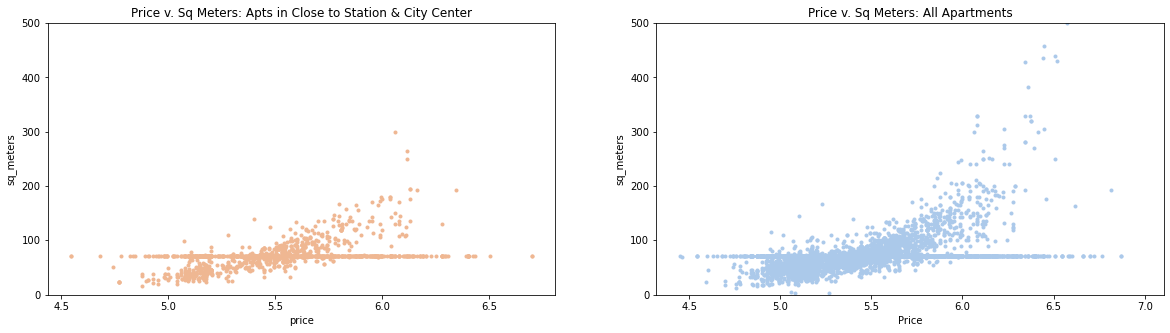

In [98]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.scatter(np.log10(apts['price']), apts['sq_meters'], marker='.', c = '#EFB792')
plt.title('Price v. Sq Meters: Apts in Close to Station & City Center')
plt.xlabel('price')
plt.ylim((-0.5,500))
plt.ylabel('sq_meters');

plt.subplot(1,2,2)
plt.scatter(np.log10(raw_data['price']), raw_data['sq_meters'], marker='.', c = '#ABC9EA')
plt.title('Price v. Sq Meters: All Apartments')
plt.xlabel('Price')
plt.ylim((-0.5,500))
plt.ylabel('sq_meters');



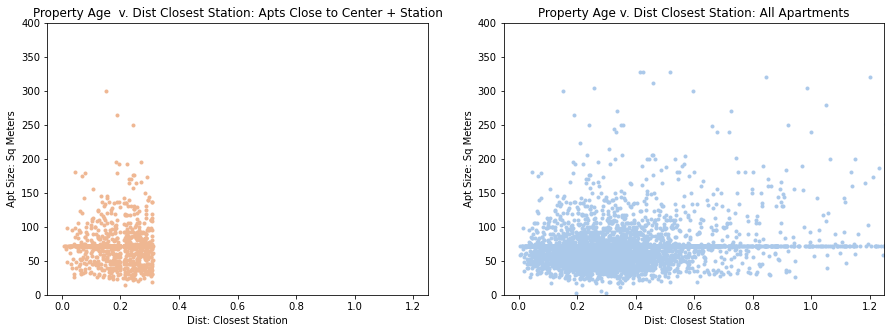

In [122]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(apts['dist_closest_station'], apts['sq_meters'], marker='.', c = '#EFB792')
plt.title('Property Age  v. Dist Closest Station: Apts Close to Center + Station')
plt.xlabel('Dist: Closest Station')
plt.ylim((-0.05,400))
plt.xlim((-0.05,1.25))
plt.ylabel('Apt Size: Sq Meters');

plt.subplot(1,2,2)
plt.scatter(raw_data['dist_closest_station'], raw_data['sq_meters'], marker='.', c = '#ABC9EA')
plt.title('Property Age v. Dist Closest Station: All Apartments')
plt.xlabel('Dist: Closest Station')
plt.ylim((-0.05,400))
plt.xlim((-0.05,1.25))
plt.ylabel('Apt Size: Sq Meters');


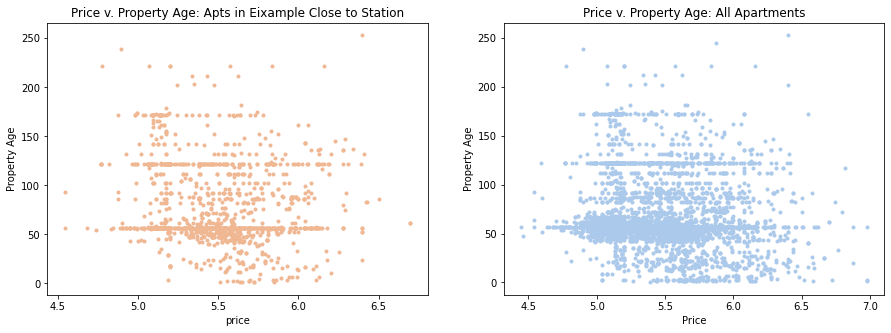

In [124]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(np.log10(apts['price']), apts['property_age'], marker='.', c = '#EFB792')
plt.title('Price v. Property Age: Apts in Eixample Close to Station')
plt.xlabel('price')
plt.ylabel('Property Age');

plt.subplot(1,2,2)
plt.scatter(np.log10(raw_data['price']), raw_data['property_age'], marker='.', c = '#ABC9EA')
plt.title('Price v. Property Age: All Apartments')
plt.xlabel('Price')
plt.ylabel('Property Age');


In [88]:
room_type_filtered = apts.groupby('rooms')['price_cat'].count().reset_index()
room_type_all = raw_data.groupby('rooms')['price_cat'].count().reset_index()

room_type_filtered.rename(columns={'price_cat':'n_rooms'},inplace=True)
room_type_all.rename(columns={'price_cat':'n_rooms2'},inplace=True)

new_row_all = {'rooms': '5+', 'n_rooms2': 238}
room_type_all = room_type_all.append(new_row_all, ignore_index = True)

new_row_filtered = {'rooms': '5+', 'n_rooms': 49}
room_type_filtered = room_type_filtered.append(new_row_filtered, ignore_index = True)

room_type_filtered

room_type_all = room_type_all.drop(labels=[5,6,7,8,9,10,11],axis=0)
room_type_filtered = room_type_filtered.drop(labels=[5,6,7,8,9],axis=0)



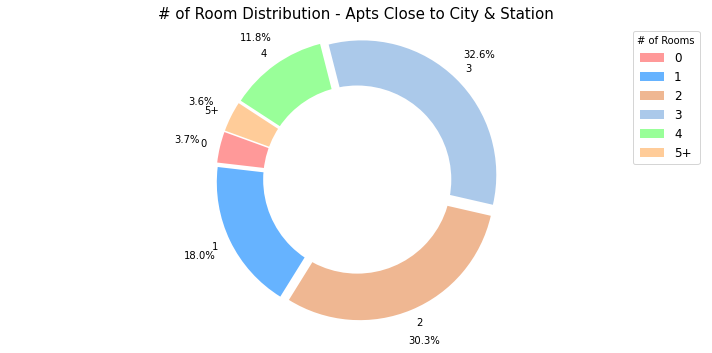

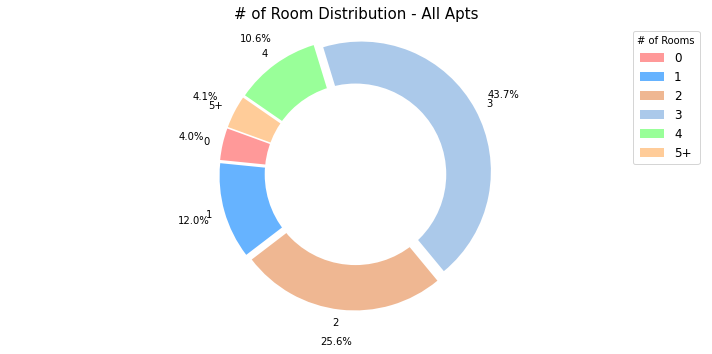

In [80]:
explode = (0.05,0.05,0.05,0.05,0.05,0.05)
labels = ['0','1','2','3','4','5+']
colors=['#ff9999','#66b3ff','#EFB792', '#ABC9EA','#99ff99', '#ffcc99']

plt.figure(figsize=(10,5))

plt.pie(room_type_filtered['n_rooms'],autopct='%1.1f%%', colors = colors, explode = explode, startangle=160, pctdistance=1.25, labels = labels)
plt.axis('equal')
plt.legend(labels=room_type_filtered['rooms'],loc='best',fontsize='12', title =  "# of Rooms")
plt.title('# of Room Distribution - Apts Close to City & Station', fontsize='15')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()



plt.figure(figsize=(10,5))
plt.pie(room_type_all['n_rooms2'],autopct='%1.1f%%', colors = colors, explode = explode, startangle=160, pctdistance=1.25, labels = labels)
plt.axis('equal')
plt.legend(labels=room_type_all['rooms'],loc='best',fontsize='12', title = "# of Rooms")
plt.title('# of Room Distribution - All Apts', fontsize='15')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.tight_layout()
plt.show()


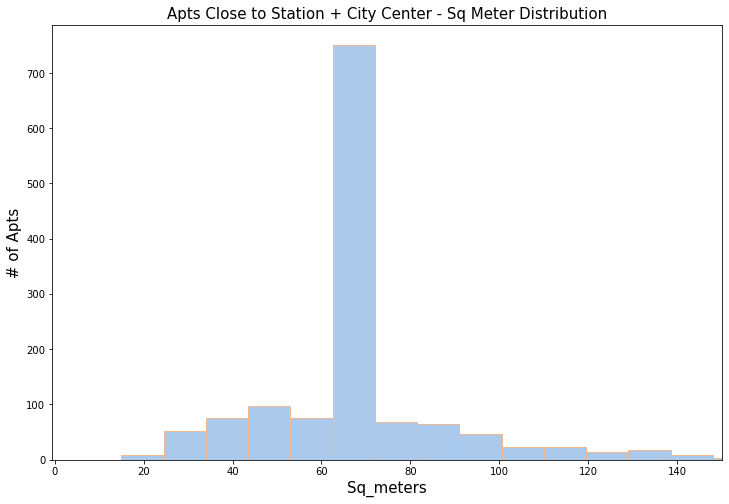

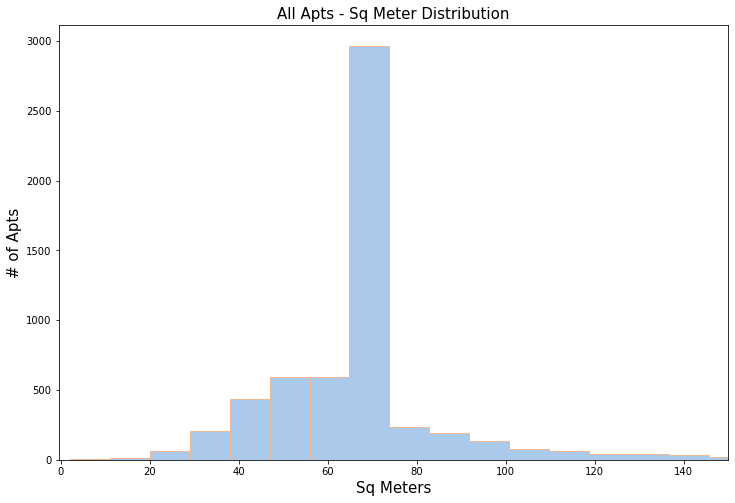

In [75]:
fig2,ax = plt.subplots(figsize=(12,8))
plt.hist(apts['sq_meters'],bins=30,color='#ABC9EA',edgecolor='#EFB792')

plt.xlabel('Sq_meters',fontsize='15')
plt.ylabel('# of Apts', fontsize='15')
plt.xlim((-0.5,150))
plt.title('Apts Close to Station + City Center - Sq Meter Distribution',fontsize='15')
plt.show()



fig2,ax = plt.subplots(figsize=(12,8))
plt.hist(raw_data['sq_meters'],bins=100,color='#ABC9EA',edgecolor='#EFB792')

plt.xlabel('Sq Meters',fontsize='15')
plt.ylabel('# of Apts', fontsize='15')
plt.xlim((-0.5,150))
plt.title('All Apts - Sq Meter Distribution',fontsize='15')
plt.show()



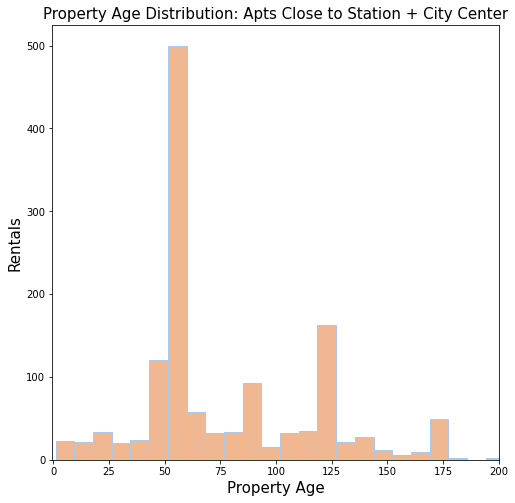

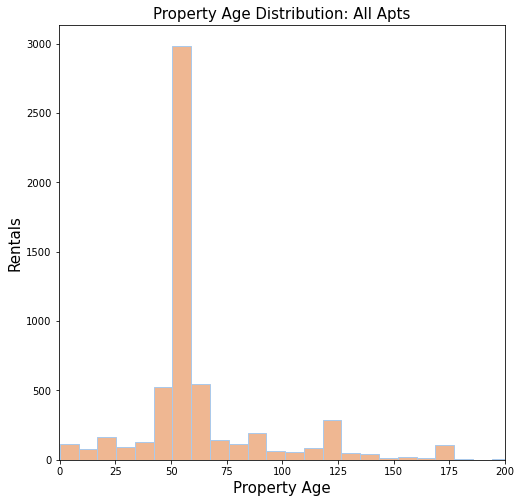

In [83]:
fig2,ax = plt.subplots(figsize=(8,8))
plt.hist(apts['property_age'],bins=30,color='#EFB792',edgecolor='#ABC9EA')

plt.xlabel('Property Age',fontsize='15')
plt.ylabel('Rentals', fontsize='15')
plt.xlim((-0.5,200))
plt.title('Property Age Distribution: Apts Close to Station + City Center',fontsize='15')
plt.show()

fig2,ax = plt.subplots(figsize=(8,8))
plt.hist(raw_data['property_age'],bins=30,color='#EFB792',edgecolor='#ABC9EA')

plt.xlabel('Property Age',fontsize='15')
plt.ylabel('Rentals', fontsize='15')
plt.xlim((-0.5,200))
plt.title('Property Age Distribution: All Apts',fontsize='15')
plt.show()

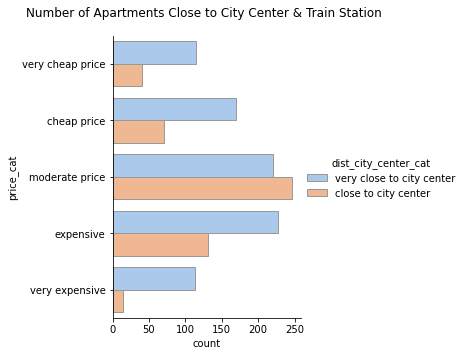

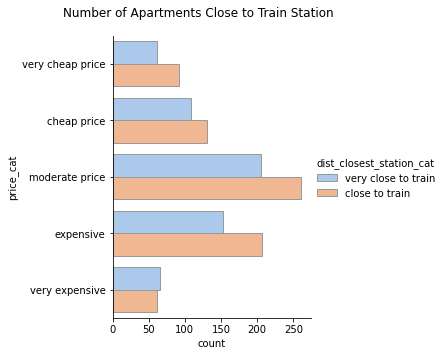

In [84]:
center_chart2 = sn.catplot(y="price_cat", hue="dist_city_center_cat", kind="count",
            order=['very cheap price',"cheap price", "moderate price", "expensive","very expensive" ],
            palette="pastel", edgecolor=".6",
            data=apts)

center_chart2.fig.subplots_adjust(top=0.9)
center_chart2.fig.suptitle('Number of Apartments Close to City Center & Train Station')


center_chart2 = sn.catplot(y="price_cat", hue="dist_closest_station_cat", kind="count",
            order=['very cheap price',"cheap price", "moderate price", "expensive","very expensive" ],
            palette="pastel", edgecolor=".6",
            data=apts)

center_chart2.fig.subplots_adjust(top=0.9)
center_chart2.fig.suptitle('Number of Apartments Close to Train Station')

None

In [85]:
prices = apts.groupby('neighborhood').agg(np.mean).apply(lambda s: s.apply('{0:.1f}'.format))
prices_clean = prices[['price', 'sq_meters', 'rooms', 'bathrooms','year_built', 'dist_city_center', 'dist_closest_station', 'property_age']]

In [86]:
print("Averages - Least Expensive Neighborhoods")

prices_clean.sort_values(by='price',ascending=True).head(n=8)

Averages - Least Expensive Neighborhoods


,price,sq_meters,rooms,bathrooms,year_built,dist_city_center,dist_closest_station,property_age
neighborhood,,,,,,,,
Can Baró,114500.0,49.5,1.7,1.0,1959.3,2.9,0.2,62.7
El Raval,172017.1,56.0,1.7,1.1,1918.2,1.0,0.2,103.8
La Bordeta,197000.0,67.6,2.3,1.3,1950.0,3.2,0.3,72.0
El Guinardó,198166.7,57.0,2.1,1.0,1963.1,3.2,0.2,58.9
La Barceloneta,207000.0,52.0,1.3,1.0,1955.7,1.7,0.3,66.3
Hostafrancs,216535.7,68.7,2.0,1.2,1936.7,2.6,0.2,85.3
El Poble Sec - Parc de Montjuïc,235321.9,62.9,2.1,1.1,1951.4,1.7,0.2,70.6
Sants-Montjuïc,237140.0,71.0,2.2,1.2,1954.5,2.3,0.2,67.5


In [87]:
print("Averages - Most Expensive Neighborhoods")
prices_clean.sort_values(by='price',ascending=False).head(n=8)

Averages - Most Expensive Neighborhoods


,price,sq_meters,rooms,bathrooms,year_built,dist_city_center,dist_closest_station,property_age
neighborhood,,,,,,,,
Sant Gervasi - Galvany,990000.0,71.4,6.0,3.0,1954.0,2.1,0.2,68.0
La Dreta de l'Eixample,876560.0,93.6,3.1,2.0,1942.7,0.9,0.2,79.3
Eixample,834283.8,76.6,3.1,2.1,1951.0,1.3,0.2,71.0
La Font de la Guatlla,749000.0,71.4,5.0,2.0,1958.0,2.5,0.3,64.0
Sarrià-Sant Gervasi,731444.4,77.2,3.2,2.2,1983.4,2.6,0.3,38.6
L'Antiga Esquerra de l'Eixample,642760.0,85.7,2.6,1.9,1933.2,1.1,0.2,88.8
La Vila Olímpica del Poblenou,620000.0,71.4,3.0,2.0,1992.0,2.2,0.3,30.0
Gràcia,544400.0,70.2,2.4,1.9,1951.2,2.1,0.2,70.8
